### based on https://github.com/higgsfield/RL-Adventure

In [1]:
%matplotlib inline
import collections
import gym
import matplotlib.pyplot as plot
import numpy as np
import random
import time
import torch as t
from IPython.display import clear_output

In [2]:
#env = gym.make('CartPole-v0')
env = gym.make('MountainCar-v0')
#env = env.unwrapped

In [3]:
class Replay(object):
    def __init__(self, maxlen=1000):
        self.buffer = collections.deque(maxlen=maxlen)
    def add(self, state, action, next_state, reward, done):
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        self.buffer.append((state, action, next_state, reward, done))
    def sample(self, n):
        state, action, next_state, reward, done = zip(*random.sample(self.buffer, n))
        state = np.concatenate(state, axis=0)
        next_state = np.concatenate(next_state, axis=0)
        reward = np.array(reward)
        done = np.array(done)
        return state, action, next_state, reward, done
    def __len__(self):
        return len(self.buffer)

In [4]:
class Model(t.nn.Module):
    def __init__(self, n_in, n_out, n_hid, dueling):
        super().__init__()
        self.dueling = dueling
        self.seq = t.nn.Sequential(
            t.nn.Linear(n_in, n_hid),            t.nn.PReLU(),
            t.nn.Linear(n_hid, n_hid),           t.nn.PReLU(),
        )
        if dueling:
            self.adv = t.nn.Sequential(
                t.nn.Linear(n_hid, n_hid),       t.nn.PReLU(),
                t.nn.Linear(n_hid, n_out)
            )
            self.val = t.nn.Sequential(
                t.nn.Linear(n_hid, n_hid),       t.nn.PReLU(),
                t.nn.Linear(n_hid, 1)
            )
        else:
            self.seq = t.nn.Sequential(
                self.seq,
                t.nn.Linear(n_hid, n_hid),       t.nn.PReLU(),
                t.nn.Linear(n_hid, n_out)
            )
    def forward(self, x):
        p = self.seq(x)
        if self.dueling:
            adv = self.adv(p)
            val = self.val(p)
            adv_mean = adv.mean(-1).unsqueeze(0)
            return val + adv - adv.mean(-1).unsqueeze(1)
        else:
            return p

def build_model(n_hidden, dueling):
    return Model(env.observation_space.shape[0], env.action_space.n, n_hidden, dueling).cuda()

In [5]:
def plot_state(desc):
    clear_output(False)
    print(desc)
    plot.figure(figsize=(24,5))
    plot.subplot(131)
    plot.title('rewards (frame=%dk, %d episodes)' % (np.round(frame/1000), len(all_rewards)))
    plot.plot(np.array(all_rewards)[:-1])
    plot.subplot(132)
    plot.title('losses')
    plot.plot(losses)
    plot.subplot(133)
    plot.title('final_positions')
    plot.plot(final_positions)
    plot.show()

In [6]:
def build_models_opt_loss(double=True, n_hidden=32, dueling=False):
    model = build_model(n_hidden, dueling)
    target_model = build_model(n_hidden, dueling) if DOUBLE_MODEL else model
    opt = t.optim.Adam(model.parameters())
    loss_fn = t.nn.SmoothL1Loss()
    return model, target_model.eval(), opt, loss_fn

In [7]:
def learn_step():
    model.train()
    q_state, q_action, q_next_state, q_reward, q_done = replay.sample(batch_size)
    q_state = t.FloatTensor(q_state).cuda()
    q_next_state = t.FloatTensor(q_next_state).cuda()

    q_values = model(q_state)
    q_next_values = target_model(q_next_state)

    q_action = t.LongTensor(q_action).cuda()
    q_value = q_values.gather(1, q_action.unsqueeze(1)).squeeze(1)
    q_next_value = q_next_values.max(1).values

    q_reward = t.FloatTensor(q_reward).cuda()
    q_done = t.FloatTensor(q_done).cuda()

    target = q_reward + gamma * q_next_value * (1 - q_done)
    loss = loss_fn(q_value, target.detach())

    opt.zero_grad()
    loss.backward()
    opt.step()
    
    return loss.item()

In [8]:
def get_action():
    if random.random() < eps:
        action = env.action_space.sample()
    else:
        model.eval()
        action = model(t.FloatTensor(state).cuda().unsqueeze(0)).squeeze(0).argmax().item()
    return action

DOUBLE_MODEL=True, MODIFIED_REWARD=True, DUELING=True, finished.


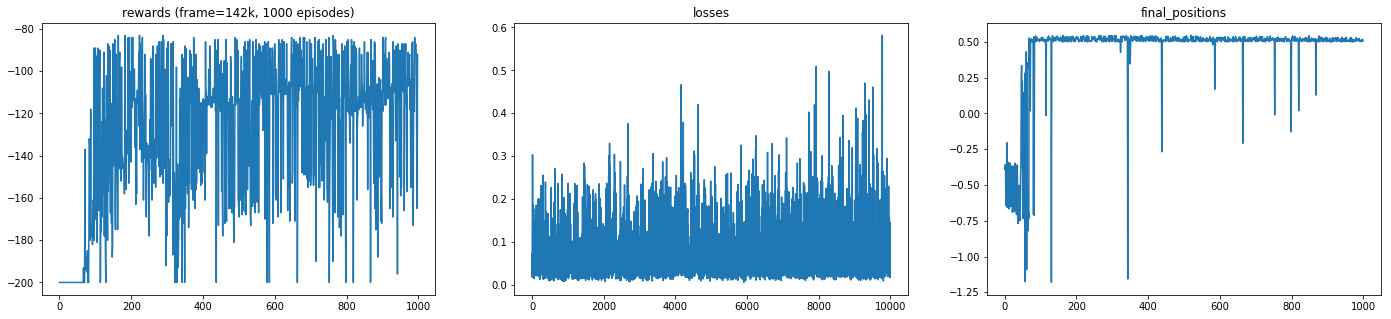

In [9]:
DOUBLE_MODEL = True
MODIFIED_REWARD = True
DUELING = True
model, target_model, opt, loss_fn = build_models_opt_loss(DOUBLE_MODEL, 32, DUELING)

eps, eps_final, eps_steps = 1, .01, 1000
eps_decay = np.exp(np.log(eps_final / eps) / eps_steps)
batch_size = 32
gamma = 0.99

losses = collections.deque(maxlen=10000)
all_rewards = collections.deque([0], maxlen=1000)
final_positions = collections.deque(maxlen=1000)
replay = Replay(10000)
state = env.reset()

MSG = f'DOUBLE_MODEL={DOUBLE_MODEL}, MODIFIED_REWARD={MODIFIED_REWARD}, DUELING={DUELING}'
for frame in range(1000 * 250):
    eps = max(eps_final, eps * eps_decay)
    action = get_action()
    next_state, reward, done, info = env.step(action)

    if MODIFIED_REWARD:
        replay.add(state, action, next_state, reward + abs(state[0] + .5), done)
    else:
        replay.add(state, action, next_state, reward, done)
    all_rewards[-1] += reward

    state = next_state    
    if done:
        final_positions.append(state[0])
        state = env.reset()
        all_rewards.append(0)
    
    if len(replay) > batch_size:
        losses.append(learn_step())
        
    if (frame + 1) % 1000 == 0 and DOUBLE_MODEL:
        target_model.load_state_dict(model.state_dict())
    
    if (frame + 1) % 10000 == 0:
        plot_state(MSG)

    if len(all_rewards) > 100 and np.mean(np.array(all_rewards)[-100:]) >= -110:
        break

plot_state(MSG + ', finished.')

DOUBLE_MODEL=True, MODIFIED_REWARD=False, DUELING=False, finished.


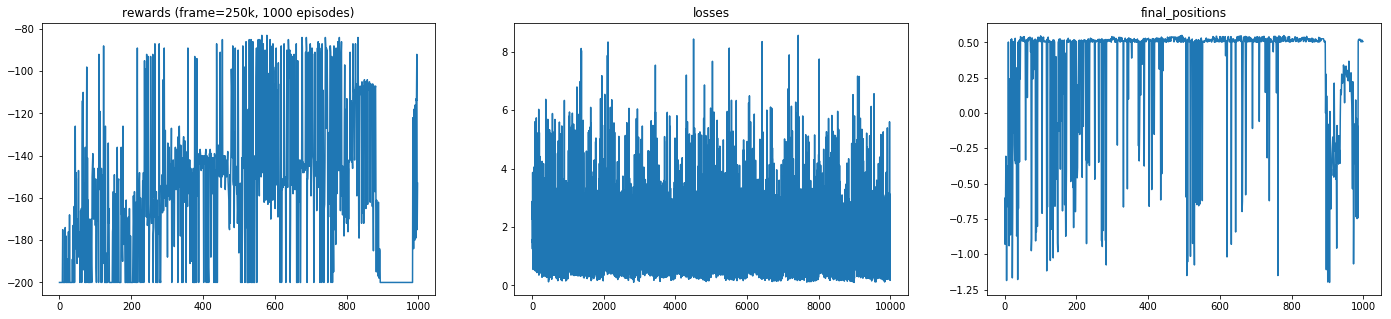

In [10]:
DOUBLE_MODEL = True
MODIFIED_REWARD = False
DUELING = False
model, target_model, opt, loss_fn = build_models_opt_loss(DOUBLE_MODEL, 32, DUELING)

eps, eps_final, eps_steps = 1, .01, 1000
eps_decay = np.exp(np.log(eps_final / eps) / eps_steps)
batch_size = 32
gamma = 0.99

losses = collections.deque(maxlen=10000)
all_rewards = collections.deque([0], maxlen=1000)
final_positions = collections.deque(maxlen=1000)
replay = Replay(10000)
state = env.reset()

MSG = f'DOUBLE_MODEL={DOUBLE_MODEL}, MODIFIED_REWARD={MODIFIED_REWARD}, DUELING={DUELING}'
for frame in range(1000 * 250):
    eps = max(eps_final, eps * eps_decay)
    action = get_action()
    next_state, reward, done, info = env.step(action)

    if MODIFIED_REWARD:
        replay.add(state, action, next_state, reward + abs(state[0] + .5), done)
    else:
        replay.add(state, action, next_state, reward, done)
    all_rewards[-1] += reward

    state = next_state    
    if done:
        final_positions.append(state[0])
        state = env.reset()
        all_rewards.append(0)
    
    if len(replay) > batch_size:
        losses.append(learn_step())
        
    if (frame + 1) % 1000 == 0 and DOUBLE_MODEL:
        target_model.load_state_dict(model.state_dict())
    
    if (frame + 1) % 10000 == 0:
        plot_state(MSG)

    if len(all_rewards) > 100 and np.mean(np.array(all_rewards)[-100:]) >= -110:
        break

plot_state(MSG + ', finished.')

DOUBLE_MODEL=True, MODIFIED_REWARD=False, DUELING=True, finished.


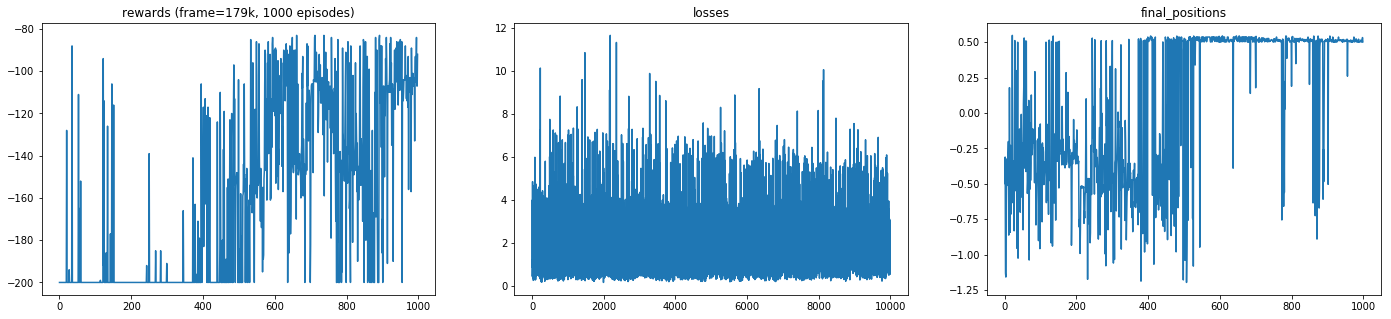

In [11]:
DOUBLE_MODEL = True
MODIFIED_REWARD = False
DUELING = True
model, target_model, opt, loss_fn = build_models_opt_loss(DOUBLE_MODEL, 32, DUELING)

eps, eps_final, eps_steps = 1, .01, 1000
eps_decay = np.exp(np.log(eps_final / eps) / eps_steps)
batch_size = 32
gamma = 0.99

losses = collections.deque(maxlen=10000)
all_rewards = collections.deque([0], maxlen=1000)
final_positions = collections.deque(maxlen=1000)
replay = Replay(10000)
state = env.reset()

MSG = f'DOUBLE_MODEL={DOUBLE_MODEL}, MODIFIED_REWARD={MODIFIED_REWARD}, DUELING={DUELING}'
for frame in range(1000 * 250):
    eps = max(eps_final, eps * eps_decay)
    action = get_action()
    next_state, reward, done, info = env.step(action)

    if MODIFIED_REWARD:
        replay.add(state, action, next_state, reward + abs(state[0] + .5), done)
    else:
        replay.add(state, action, next_state, reward, done)
    all_rewards[-1] += reward

    state = next_state    
    if done:
        final_positions.append(state[0])
        state = env.reset()
        all_rewards.append(0)
    
    if len(replay) > batch_size:
        losses.append(learn_step())
        
    if (frame + 1) % 1000 == 0 and DOUBLE_MODEL:
        target_model.load_state_dict(model.state_dict())
    
    if (frame + 1) % 10000 == 0:
        plot_state(MSG)

    if len(all_rewards) > 100 and np.mean(np.array(all_rewards)[-100:]) >= -110:
        break

plot_state(MSG + ', finished.')

DOUBLE_MODEL=False, MODIFIED_REWARD=False, DUELING=True, finished.


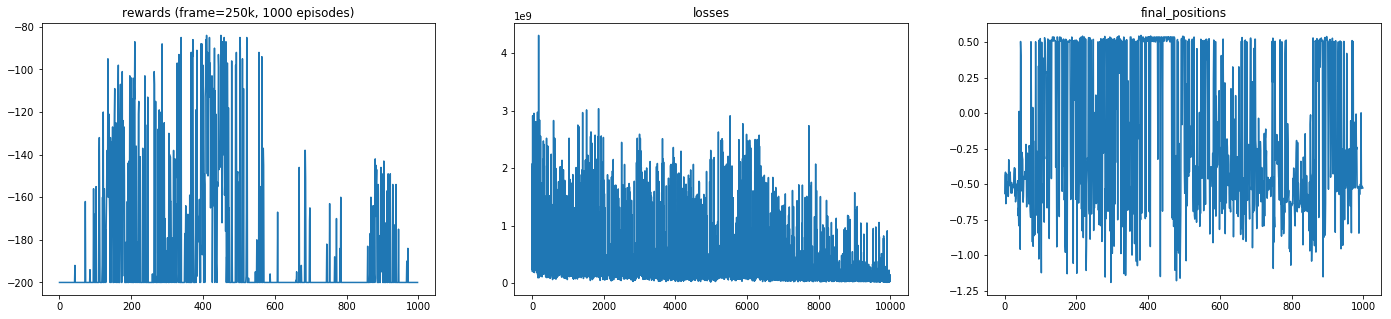

In [12]:
DOUBLE_MODEL = False
MODIFIED_REWARD = False
DUELING = True
model, target_model, opt, loss_fn = build_models_opt_loss(DOUBLE_MODEL, 32, DUELING)

eps, eps_final, eps_steps = 1, .01, 1000
eps_decay = np.exp(np.log(eps_final / eps) / eps_steps)
batch_size = 32
gamma = 0.99

losses = collections.deque(maxlen=10000)
all_rewards = collections.deque([0], maxlen=1000)
final_positions = collections.deque(maxlen=1000)
replay = Replay(10000)
state = env.reset()

MSG = f'DOUBLE_MODEL={DOUBLE_MODEL}, MODIFIED_REWARD={MODIFIED_REWARD}, DUELING={DUELING}'
for frame in range(1000 * 250):
    eps = max(eps_final, eps * eps_decay)
    action = get_action()
    next_state, reward, done, info = env.step(action)

    if MODIFIED_REWARD:
        replay.add(state, action, next_state, reward + abs(state[0] + .5), done)
    else:
        replay.add(state, action, next_state, reward, done)
    all_rewards[-1] += reward

    state = next_state    
    if done:
        final_positions.append(state[0])
        state = env.reset()
        all_rewards.append(0)
    
    if len(replay) > batch_size:
        losses.append(learn_step())
        
    if (frame + 1) % 1000 == 0 and DOUBLE_MODEL:
        target_model.load_state_dict(model.state_dict())
    
    if (frame + 1) % 10000 == 0:
        plot_state(MSG)

    if len(all_rewards) > 100 and np.mean(np.array(all_rewards)[-100:]) >= -110:
        break

plot_state(MSG + ', finished.')